# SoC Estimation

## Setting up Environment

### Importing library

In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
import os
import matplotlib.pyplot as plt

### Setup Function for calculating SoC

In [3]:
def calculate_soc(max_capacity_ah, current_values, time_intervals):
    # Ensure there are at least two data points for trapezoidal integration
    if len(current_values) < 2 or len(time_intervals) < 1:
        raise ValueError("Insufficient data points for trapezoidal integration")

    # Calculate charge added using trapezoidal rule
    charge_added_ah = 0
    for i in range(1, len(current_values)):
        average_current = (current_values[i - 1] + current_values[i])/2 
        charge_added_ah += average_current * time_intervals[i - 1]  # ΔT is time_intervals[i-1]

    # Update the value
    x_new = (charge_added_ah / max_capacity_ah)

    return x_new

In [4]:
def calculate_soc_discharged(max_capacity_ah, current_values, time_intervals):
    # Ensure there are at least two data points for trapezoidal integration
    if len(current_values) < 2 or len(time_intervals) < 1:
        raise ValueError("Insufficient data points for trapezoidal integration")

    # Calculate charge added using trapezoidal rule
    charge_added_ah = 0
    for i in range(1, len(current_values)):
        average_current = (current_values[i - 1] + current_values[i])/2 
        charge_added_ah += average_current * time_intervals[i - 1]  # ΔT is time_intervals[i-1]

    # Update the value
    x_new = (charge_added_ah / max_capacity_ah)

    return x_new

## Data Proccessing 

### Importing data

In [5]:
file_path = '..\data\Battery Data_All.xlsx'  
sheet_name = '10 Ampere Discharging'  

# Read the Excel file
data = pd.read_excel(file_path, sheet_name=sheet_name)

measured_voltage=data['Voltage_24102024 (mV)'].values/1000
measured_voltage_flipped = (data['Voltage_24102024 (mV)'].max()-(data['Voltage_24102024 (mV)']-data['Voltage_24102024 (mV)'].min())).values/1000 # Adjust column name if different
Time = data['Time (s)'].values
data

,Time (s),Voltage_16102024 (mV),Voltage_24102024 (mV),Voltage_28102024 (mV),Voltage_30102024 (mV),Capacity_16102024 (Ah),Capacity_24102024 (Ah),Capacity_28102024 (Ah),Capacity_30102024 (Ah)
0,0,3410.0,4190,3900.0,3930.0,20.258333,69.608333,49.150000,45.783333
1,3,3410.0,4190,3900.0,3930.0,20.250000,69.600000,49.141667,45.775000
2,6,3410.0,4190,3900.0,3930.0,20.241667,69.591667,49.133333,45.766667
3,9,3410.0,4190,3900.0,3930.0,20.233333,69.583333,49.125000,45.758333
4,12,3410.0,4190,3900.0,3930.0,20.225000,69.575000,49.116667,45.750000
...,...,...,...,...,...,...,...,...,...
8349,25047,NaN,2500,NaN,NaN,NaN,0.033333,NaN,NaN
8350,25050,NaN,2500,NaN,NaN,NaN,0.025000,NaN,NaN
8351,25053,NaN,2500,NaN,NaN,NaN,0.016667,NaN,NaN
8352,25056,NaN,2500,NaN,NaN,NaN,0.008333,NaN,NaN


### Labeling SoC

In [6]:
# Define a consistent time step for each interval in seconds 
time_step_seconds = 3
time_intervals_hours = time_step_seconds / 3600  # Convert seconds to hours

# Create a list of time intervals (same value for each step)
time_intervals = [time_intervals_hours] * (len(data) - 1)

# Estimate the initial SoC based on the first voltage measurement
initial_soc = 1


current_values = []
for  i in range(1,len(data)):
    # Extract data for calculations
    x = -(data.loc[i,'Capacity_24102024 (Ah)']-data.loc[i-1,'Capacity_24102024 (Ah)'])*3600/time_step_seconds
    current_values.append(x)

current_values.insert(0,sum(current_values)/len(current_values))  


In [7]:
# Add SoC result to the DataFrame
data['SoC (%)'] = [initial_soc * 100] + [None] * (len(data) - 1)  # Fill initial SoC
for i in range(1, len(data)):
    x =  calculate_soc_discharged(max_capacity_ah=data.loc[0,'Capacity_24102024 (Ah)'], current_values=current_values[:i+1], time_intervals=time_intervals)
    data.loc[i, 'SoC (%)'] = max(0.0, min((initial_soc-x)*100, 100))

SOC = data['SoC (%)'].values

### Plotting Voltage vs SoC

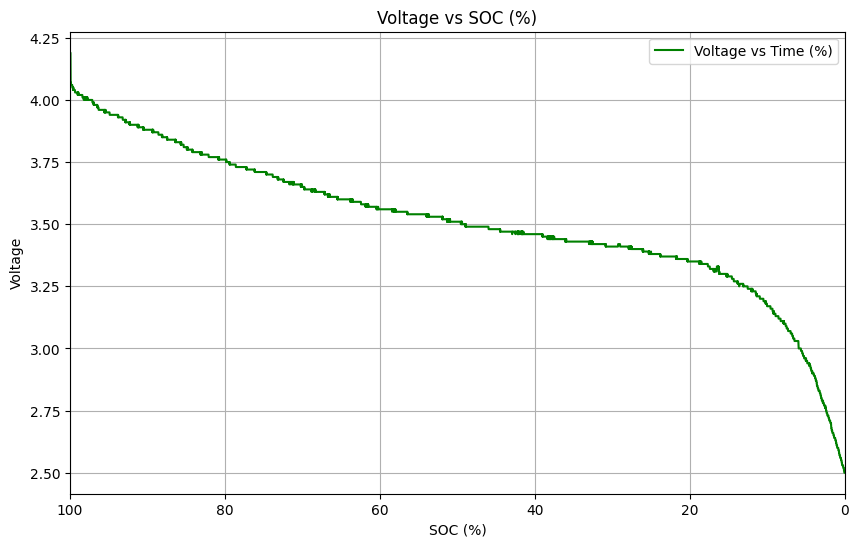

In [8]:

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(SOC,measured_voltage, label='Voltage vs Time (%)', color='g')
plt.xlabel('SOC (%)')
plt.ylabel('Voltage')
plt.title('Voltage vs SOC (%)')
plt.legend()
plt.grid(True)
plt.xlim(100,0)
plt.show()

### Creating Projection

#### Checking the data

In [9]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data)

      Time (s)  Voltage_16102024 (mV)  Voltage_24102024 (mV)  \
0            0                 3410.0                   4190   
1            3                 3410.0                   4190   
2            6                 3410.0                   4190   
3            9                 3410.0                   4190   
4           12                 3410.0                   4190   
5           15                 3410.0                   4190   
6           18                 3410.0                   4190   
7           21                 3410.0                   4070   
8           24                 3410.0                   4070   
9           27                 3400.0                   4070   
10          30                 3410.0                   4070   
11          33                 3410.0                   4070   
12          36                 3410.0                   4060   
13          39                 3410.0                   4060   
14          42                 3410.0   

There are some non-unique data, this will be a problem when interpolating since it will either become infinite or zero. Therefore we need to filter to it until all data is unique.

#### Agregating data

In [10]:
x = data["Voltage_24102024 (mV)"].unique()
y = np.zeros(len(x))
for i in range(len(x)-1):
    y[i] = data["SoC (%)"].loc[data['Voltage_24102024 (mV)'] == x[i]].max()

#### Creating interpolation

In [44]:
# Create an interpolation function for SOC based on OCV
soc_from_TV = interp1d(x, y, kind='cubic', fill_value="extrapolate")
TV_from_soc = interp1d(y, x, kind='cubic', fill_value="extrapolate")

In [12]:
def estimate_initial_soc_from_ocv(voltage):
    # Predict SoC using interpolation function
    estimated_soc_percentage = soc_from_TV(voltage*1000)/100
    return estimated_soc_percentage   # Convert to fraction

#### Testing interpolation in data with simillar characteristic

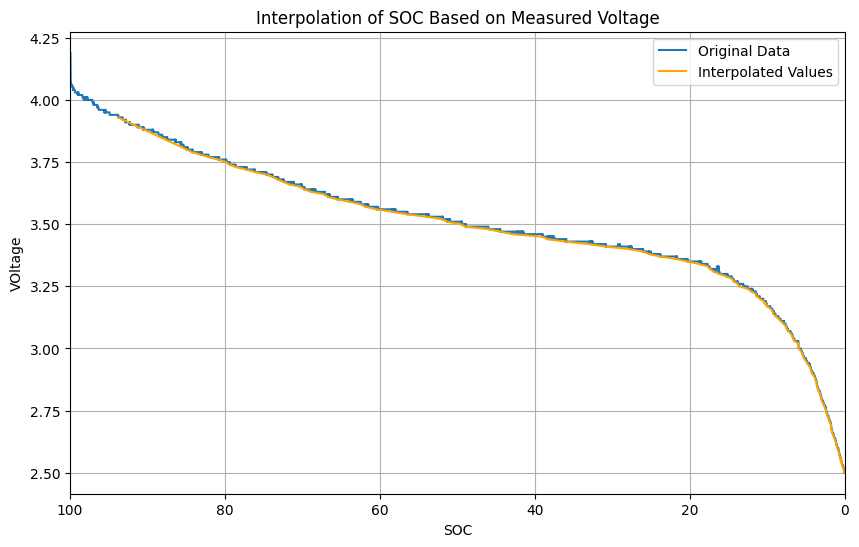

In [15]:
# Generate some test values to see how the function interpolates/extrapolates
test_voltages = data['Voltage_30102024 (mV)'].values # Values to test the interpolation (including extrapolation range)
interpolated_soc = soc_from_TV(test_voltages)


interpolated_soc
# Plot the results for visualization
plt.figure(figsize=(10, 6))
plt.plot(SOC, measured_voltage, '-', label='Original Data', markersize=8)   
plt.plot(interpolated_soc,  test_voltages/1000, '-', label='Interpolated Values', color='orange')
plt.xlabel('SOC')
plt.ylabel('VOltage')
plt.title('Interpolation of SOC Based on Measured Voltage')
plt.legend()
plt.grid(True)
plt.xlim(100,0)
plt.show()

#### Testing with other data

In [14]:
sheet_name_1 = '10 Ampere Charging'  

# Read the Excel file
data_1 = pd.read_excel(file_path, sheet_name=sheet_name_1)
Time_2 = data_1['Time (s)'].values
len(Time_2)

10077

In [15]:
data_1

,Time (s),Voltage_21102024 (mV),Voltage_25102024 (mV),Voltage_29102024 (mV),Current_21102024 (mA),Current_25102024 (mA),Current_29102024 (mA)
0,0,2500,3360.0,3000.0,10010,10010.0,10010.0
1,3,2500,3700.0,3400.0,10010,10010.0,10010.0
2,6,2520,3720.0,3420.0,10010,10010.0,10010.0
3,9,2520,3720.0,3420.0,10010,10010.0,10010.0
4,12,2530,3700.0,3420.0,10010,10010.0,10010.0
...,...,...,...,...,...,...,...
10072,30216,4210,NaN,NaN,7610,NaN,NaN
10073,30219,4210,NaN,NaN,7450,NaN,NaN
10074,30222,4210,NaN,NaN,7580,NaN,NaN
10075,30225,4210,NaN,NaN,7590,NaN,NaN


In [16]:
# Estimate the initial SoC based on the first voltage measurement
initial_voltage_1 = data_1['Voltage_21102024 (mV)'].iloc[0]/1000
initial_soc_1= estimate_initial_soc_from_ocv(initial_voltage_1)
initial_soc_1

np.float64(0.0)

In [17]:
# Define a consistent time step for each interval in seconds 
time_step_seconds = 3
time_intervals_hours = time_step_seconds / 3600  # Convert seconds to hours

# Create a list of time intervals (same value for each step)
time_intervals_1 = [time_intervals_hours] * (len(data_1) - 1)

# Estimate the initial SoC based on the first voltage measurement
initial_voltage_1 = data_1['Voltage_21102024 (mV)'].iloc[0]/1000
initial_soc_1= estimate_initial_soc_from_ocv(initial_voltage_1)

# Extract data for calculations
current_values_1 = data_1['Current_21102024 (mA)'].values/1000

In [18]:
# Add SoC result to the DataFrame
data_1['Estimated SoC (%)'] = [initial_soc_1 * 100] + [None] * (len(data_1) - 1)  # Fill initial SoC
for i in range(1, len(data_1)):
    x_2 = calculate_soc(max_capacity_ah=112.6, current_values=current_values_1[:i+1], time_intervals=time_intervals_1[:i])
    data_1.loc[i, 'Estimated SoC (%)'] = max(0.0, min((initial_soc_1+x_2)*100, 100))



In [19]:
SOC_1 = data_1['Estimated SoC (%)']
data_1


,Time (s),Voltage_21102024 (mV),Voltage_25102024 (mV),Voltage_29102024 (mV),Current_21102024 (mA),Current_25102024 (mA),Current_29102024 (mA),Estimated SoC (%)
0,0,2500,3360.0,3000.0,10010,10010.0,10010.0,0.000000
1,3,2500,3700.0,3400.0,10010,10010.0,10010.0,0.007408
2,6,2520,3720.0,3420.0,10010,10010.0,10010.0,0.014816
3,9,2520,3720.0,3420.0,10010,10010.0,10010.0,0.022225
4,12,2530,3700.0,3420.0,10010,10010.0,10010.0,0.029633
...,...,...,...,...,...,...,...,...
10072,30216,4210,NaN,NaN,7610,NaN,NaN,74.227879
10073,30219,4210,NaN,NaN,7450,NaN,NaN,74.233452
10074,30222,4210,NaN,NaN,7580,NaN,NaN,74.239013
10075,30225,4210,NaN,NaN,7590,NaN,NaN,74.244627


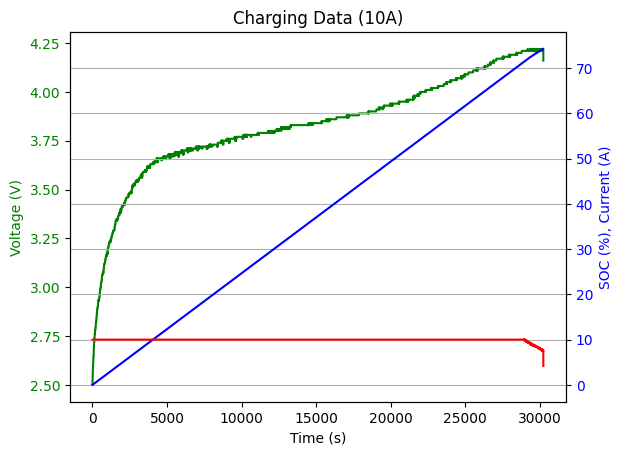

In [185]:
fig, ax1 = plt.subplots()
# plot measured voltage vs time
ax1.plot(data_1['Time (s)'], data_1['Voltage_21102024 (mV)'].values/1000, 'g-')  # 'g-' specifies a green line
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Plot Estimated SoC vs. Time
ax2 = ax1.twinx() 
ax2.plot(data_1['Time (s)'], data_1['Estimated SoC (%)'], 'b-')  # 'b-' specifies a blue line
ax2.plot(data_1['Time (s)'], current_values_1, 'r-')
ax2.set_ylabel('SOC (%), Current (A)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Charging Data (10A)')
plt.grid(True)
plt.show()

In [38]:
sheet_name_2 = '20 Ampere Charging'  # Change this to the name of your sheet if it's different

# Read the Excel file
data_2 = pd.read_excel(file_path, sheet_name=sheet_name_2)
data_2

,Time (s),Voltage_02102024 (mV),Voltage_07102024 (mV),Voltage_09102024 (mV),Current_02102024 (mA),Current_07102024 (mA),Current_09102024 (mA)
0,0,3760.0,3220.0,3630,20400.0,20400.0,20
1,3,4010.0,3470.0,3890,20400.0,20400.0,20400
2,6,4010.0,3470.0,3890,20400.0,20400.0,20400
3,9,4010.0,3470.0,3890,20400.0,20400.0,20400
4,12,4010.0,3480.0,3900,20400.0,20400.0,20400
...,...,...,...,...,...,...,...
8861,26583,NaN,NaN,4200,NaN,NaN,3370
8862,26586,NaN,NaN,4200,NaN,NaN,3410
8863,26589,NaN,NaN,4200,NaN,NaN,3250
8864,26592,NaN,NaN,4200,NaN,NaN,3270


In [39]:
#cleaning data
voltage_2 = data_2['Voltage_07102024 (mV)']
current_2 = data_2['Current_07102024 (mA)']

voltage_2_cleaned = voltage_2.dropna()/1000
current_2_cleaned = current_2.dropna()

Time_2 = data_2['Time (s)'].iloc[:len(voltage_2_cleaned)]

In [ ]:
# Define a consistent time step for each interval in seconds 
time_step_seconds = 3
time_intervals_hours = time_step_seconds / 3600  # Convert seconds to hours

# Create a list of time intervals (same value for each step)
time_intervals_2 = [time_intervals_hours] * (len(voltage_2) - 1)
# Estimate the initial SoC based on the first voltage measurement
initial_voltage_2 = voltage_2_cleaned.iloc[0]
initial_soc_2 = estimate_initial_soc_from_ocv(initial_voltage_2)

# Extract data for calculations
current_values_2 = current_2_cleaned/1000



0       20.40
1       20.40
2       20.40
3       20.40
4       20.40
        ...  
7379     3.64
7380     3.66
7381     3.67
7382     3.58
7383     3.69
Name: Current_07102024 (mA), Length: 7384, dtype: float64

In [ ]:
SOC_xx = [initial_soc_2 * 100] + [None] * (len(data_2) - 1) 
SOC_2 = pd.Series(SOC_xx, name='SOC')

0       11.504849
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
8861          NaN
8862          NaN
8863          NaN
8864          NaN
8865          NaN
Name: SOC, Length: 8866, dtype: float64

In [ ]:
# Add SoC result to the DataFrame
SOC_2 = pd.Series([initial_soc_2 * 100] + [None] * (len(current_values_2) - 1), name ='Estimated SoC (%)')
for i in range(1, len(current_2_cleaned)):
    x_3 = calculate_soc(max_capacity_ah=112.6, current_values=current_values_2[:i+1], time_intervals=time_intervals_2[:i])
    SOC_2.loc[i] = max(0,min((initial_soc_2+x_3)*100,100))


11.51994624835186
11.535043939293246
11.550141630234632
11.565239321176017
11.580337012117404
11.595434703058787
11.610532394000174
11.625630084941559
11.640727775882945
11.655825466824329
11.670923157765715
11.686020848707102
11.701118539648487
11.716216230589872
11.731313921531257
11.746411612472643
11.761509303414028
11.776606994355413
11.791704685296798
11.806802376238185
11.82190006717957
11.836997758120955
11.852095449062341
11.867193140003726
11.882290830945113
11.897388521886496
11.912486212827883
11.927583903769268
11.942681594710654
11.95777928565204
11.972876976593424
11.98797466753481
12.003072358476196
12.01817004941758
12.033267740358966
12.048365431300352
12.063463122241737
12.078560813183122
12.093658504124507
12.108756195065894
12.123853886007279
12.138951576948664
12.154049267890048
12.169146958831435
12.184244649772822
12.199342340714207
12.214440031655592
12.229537722596977
12.244635413538363
12.259733104479748
12.274830795421133
12.289928486362518
12.30502617730390

In [43]:
SOC_2

0       11.504849
1       11.519946
2       11.535044
3       11.550142
4       11.565239
          ...    
7379    99.033009
7380    99.035710
7381    99.038422
7382    99.041105
7383    99.043795
Name: Estimated SoC (%), Length: 7384, dtype: float64

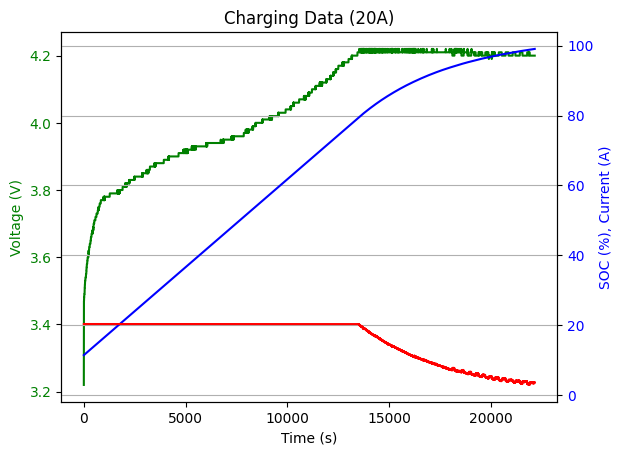

In [44]:
# # Plot Estimated SoC vs. Time
# plt.figure(figsize=(10, 6))
# plt.plot(data_2['Time (s)'], data_2['Estimated SoC (%)'], linestyle='-', color='b')
# plt.title('Estimated SoC vs. Time')
# plt.xlabel('Time (hours)')
# plt.ylabel('Estimated SoC (%)')
# plt.grid(True)
# plt.show()

fig, ax1 = plt.subplots()
# plot measured voltage vs time
ax1.plot(Time_2,voltage_2_cleaned, 'g-')  # 'g-' specifies a green line
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Plot Estimated SoC vs. Time
ax2 = ax1.twinx() 
ax2.plot(Time_2, SOC_2, 'b-')  # 'b-' specifies a blue line
ax2.plot(Time_2, current_values_2, 'r-')
ax2.set_ylabel('SOC (%), Current (A)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Charging Data (20A)')
plt.grid(True)
plt.show()

## SoC with ECC (CC + DCR)

From the graph of DCR in the datasheet   we can create a fuction which gets the DCR from SoC

In [26]:
def DCRfromSoC(SoC):
    return (5500/(SoC+15)**4+ 18000/(SoC+15)**3-500/(SoC+15)**2+6.3/(SoC+15)+1.1)/1000

In [16]:
sheet_name_1 = '10 Ampere Charging'  

# Read the Excel file
data_1 = pd.read_excel(file_path, sheet_name=sheet_name_1)
Time_2 = data_1['Time (s)'].values

10077

In [47]:
data_1

,Time (s),Voltage_21102024 (mV),Voltage_25102024 (mV),Voltage_29102024 (mV),Current_21102024 (mA),Current_25102024 (mA),Current_29102024 (mA),Estimated SoC (%)
0,0,2500,3360.0,3000.0,10010,10010.0,10010.0,0.420101
1,3,2500,3700.0,3400.0,10010,10010.0,10010.0,0.427510
2,6,2520,3720.0,3420.0,10010,10010.0,10010.0,0.434918
3,9,2520,3720.0,3420.0,10010,10010.0,10010.0,0.442326
4,12,2530,3700.0,3420.0,10010,10010.0,10010.0,0.449734
...,...,...,...,...,...,...,...,...
10072,30216,4210,NaN,NaN,7610,NaN,NaN,NaN
10073,30219,4210,NaN,NaN,7450,NaN,NaN,NaN
10074,30222,4210,NaN,NaN,7580,NaN,NaN,NaN
10075,30225,4210,NaN,NaN,7590,NaN,NaN,NaN


In [29]:
# Estimate the initial SoC based on the first voltage measurement
initial_voltage_1 = data_1['Voltage_21102024 (mV)'].iloc[0]/1000
initial_soc_1= estimate_initial_soc_from_ocv(initial_voltage_1)
initial_dcr1 = DCRfromSoC(initial_soc)
initial_current1 = data_1['Current_21102024 (mA)'].iloc[0]/1000
initial_soc_1 = estimate_initial_soc_from_ocv(initial_voltage_1+initial_current1*initial_dcr1)

np.float64(0.0042010134255012)

In [32]:
# Define a consistent time step for each interval in seconds 
time_step_seconds = 3
time_intervals_hours = time_step_seconds / 3600  # Convert seconds to hours

# Create a list of time intervals (same value for each step)
time_intervals_1 = [time_intervals_hours] * (len(data_1) - 1)

# Estimate the initial SoC based on the first voltage measurement
initial_voltage_1 = data_1['Voltage_21102024 (mV)'].iloc[0]/1000
initial_soc_1= estimate_initial_soc_from_ocv(initial_voltage_1)
initial_dcr1 = DCRfromSoC(initial_soc)
initial_current1 = data_1['Current_21102024 (mA)'].iloc[0]/1000
initial_soc_1 = estimate_initial_soc_from_ocv(initial_voltage_1+initial_current1*initial_dcr1)
# Extract data for calculations

current_values_1 = data_1['Current_21102024 (mA)'].values/1000

In [43]:
# Add SoC result to the DataFrame
data_1['Estimated SoC (%)'] = [initial_soc_1 * 100] + [None] * (len(data_1) - 1)  # Fill initial SoC
for i in range(1, len(data_1)):
    x_2 = calculate_soc(max_capacity_ah=112.6, current_values=current_values_1[:i+1], time_intervals=time_intervals_1[:i])
    data_1.loc[i, 'Estimated SoC (%)'] = max(0.0, min((initial_soc_1+x_2)*100, 100))

0        0.420101
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
10072         NaN
10073         NaN
10074         NaN
10075         NaN
10076         NaN
Name: Estimated SoC (%), Length: 10077, dtype: float64


KeyboardInterrupt: 

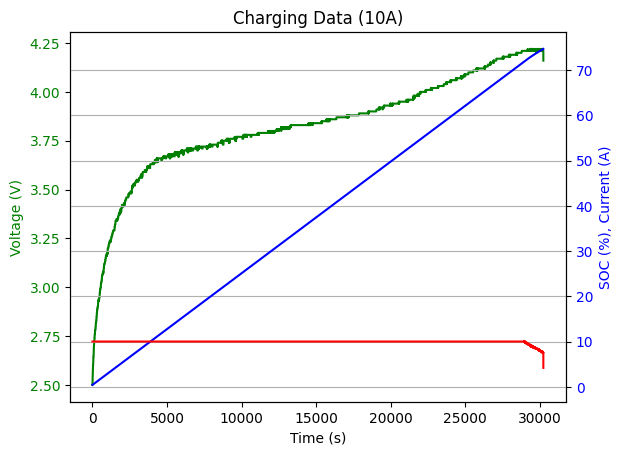

In [34]:
fig, ax1 = plt.subplots()
# plot measured voltage vs time
ax1.plot(data_1['Time (s)'], data_1['Voltage_21102024 (mV)'].values/1000, 'g-')  # 'g-' specifies a green line
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Plot Estimated SoC vs. Time
ax2 = ax1.twinx() 
ax2.plot(data_1['Time (s)'], data_1['Estimated SoC (%)'], 'b-')  # 'b-' specifies a blue line
ax2.plot(data_1['Time (s)'], current_values_1, 'r-')
ax2.set_ylabel('SOC (%), Current (A)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Charging Data (10A)')
plt.grid(True)
plt.show()

In [ ]:
final_ocv1 =  data_1["Voltage_21102024 (mV)"].iloc[len(data_1)-1]
final_soc1 =  data_1["Estimated SoC (%)"].iloc[len(data_1)-1]

In [49]:
final_ocv1

np.int64(4160)

In [46]:
final_soc1

np.float64(74.66908372857615)

In [50]:
soc_from_TV(4160)   

array(98.3284342)

In [45]:
TV_from_soc(final_soc1)

array(3699.90593267)